In [1]:
%matplotlib inline

In [2]:
import cv2
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib
import numpy as np
from pathlib import Path
from skimage.color import rgba2rgb
from skimage.io import imread
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder, DatasetFolder
import torchvision.utils as vutils

## Dataset and Data Loader

In [3]:
def show_batch(dl, limit=64):
    """Display a batch of images.
    
    Parameters
    -----------
    dl: DataLoader
    limit: int
        Max # of images to display (since we usually don't need to see all 128
        images in the batch).
    """
    batch = next(iter(dl))
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(np.transpose(vutils.make_grid(batch[0][:limit], normalize=True, 
                                             nrow=8), (1, 2, 0)))
    plt.axis('off')
    plt.show()

In [4]:
ngpu = 1
workers = 2
img_size = 64
input_c = 100
bs = 64
root = 'sketch_data/photo/tx_000100000000'
device = torch.device('cuda:0' if torch.cuda.is_available() and ngpu > 0 
                      else 'cpu')

In [5]:
tfms = transforms.Compose([transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Normalize([.5, .5, .5], [.5, .5, .5])])

photo_ds = ImageFolder(root, transform=tfms)
photo_dl = DataLoader(photo_ds, batch_size=bs, shuffle=True, 
                      num_workers=workers)

In [6]:
batch = next(iter(photo_dl))
batch[0].shape, batch[1].shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

In [7]:
# For testing, try folder that contains: camel, giraffe, horse, zebra
root_small = root + '/tmp'

small_ds = ImageFolder(root_small, transform=tfms)
small_dl = DataLoader(small_ds, batch_size=bs, shuffle=True, 
                      num_workers=workers)

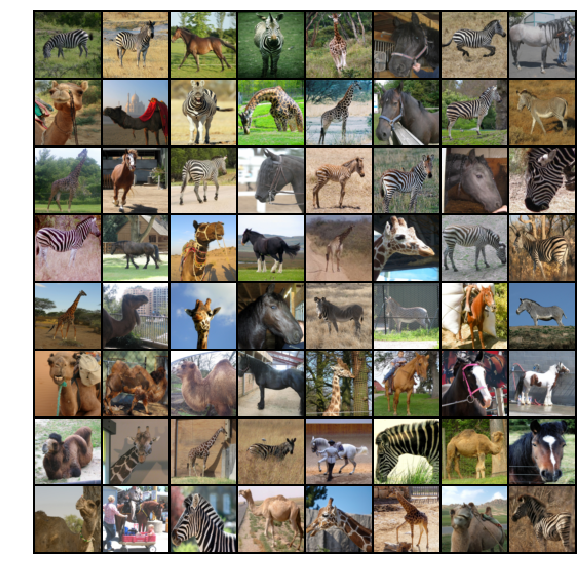

In [8]:
show_batch(small_dl)

In [149]:
class DaVinciDS(Dataset):
    
    def __init__(self, path, size, tfms=False):
        """
        Parameters
        -----------
        tfms: list
            Transforms, not including normalize.
        """
        super().__init__()
        self.files = [str(file) for file in list(Path(path).iterdir()) 
                      if 'gt' not in str(file)]
        self.tfms = tfms
        self.size = size
        
    def __getitem__(self, i):
        img = cv2.cvtColor(cv2.imread(self.files[i]), cv2.COLOR_BGR2RGB)
        if self.tfms:
            img = self.resize(img)
        img = self.normalize(img/255)    
        return img
    
    def __len__(self):
        return len(self.files)

    def resize(self, img):
        w, h, _ = img.shape
        return cv2.resize(img, (self.size, self.size))
    
    def normalize(self, img):
        stats = np.array([[.5, .5, .5],
                          [.5, .5, .5]])
        return (img - stats[0]) / stats[1]

In [150]:
root_dv = 'davinci_data/train'
dv_tfms = transforms.Compose([transforms.Resize(img_size),
                              transforms.ToTensor()])

dv_ds = DaVinciDS(root_dv, img_size, dv_tfms)
dv_dl = DataLoader(dv_ds, batch_size=36, shuffle=True, num_workers=workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


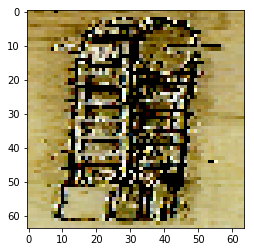

In [151]:
plt.imshow(dv_ds[0])
plt.show()

## Models

In [9]:
def conv(strided, c_in, c_out, f, stride, pad, bias=False, bn=True):
    """Create deconv block consisting of a backward strided convolution 
    optionally followed by a batch norm layer.
    """
    if strided:
        conv_ = nn.ConvTranspose2d(c_in, c_out, f, stride, pad, bias=bias)
    else:
        conv_ = nn.Conv2d(c_in, c_out, f, stride, pad, bias=bias)
    conv_.weight.data.normal_(0.0, 0.02)
    layers = [conv_]
    if bn:
        bn_ = nn.BatchNorm2d(c_out)
        bn_.weight.data.normal_(1.0, 0.02)
        bn_.bias.data.zero_()
        layers.append(bn_)
    return nn.Sequential(*layers)

In [10]:
class Generator(nn.Module):
    
    def __init__(self, input_c=100, final_c=64):
        super().__init__()
        # 100 x 1 x 1 -> 512 x 4 x 4
        self.deconv1 = conv(True, input_c, final_c*8, f=4, stride=1, pad=0)
        # 512 x 4 x 4 -> 256 x 8 x 8
        self.deconv2 = conv(True, final_c*8, final_c*4, 4, 2, 1)
        # 256 x 8 x 8 -> 128 x 16 x 16
        self.deconv3 = conv(True, final_c*4, final_c*2, 4, 2, 1)
        # 128 x 16 x 16 -> 64 x 32 x 32
        self.deconv4 = conv(True, final_c*2, final_c, 4, 2, 1)
        # 64 x 32 x 32 -> 3 x 64 x 64
        self.deconv5 = conv(True, final_c, 3, 4, 2, 1, bn=False)
        
    def forward(self, x):
        x = F.relu(self.deconv1(x), True)
        x = F.relu(self.deconv2(x), True)
        x = F.relu(self.deconv3(x), True)
        x = F.relu(self.deconv4(x), True)
        x = torch.tanh(self.deconv5(x))
        return x

    def dims(self):
        """Get shape of each layer's weights."""
        return [p.shape for p in self.parameters()]
    
    def trainable(self):
        """Check which layers are trainable."""
        return [p.requires_grad for p in self.parameters()]
    
    def layer_stats(self):
        """Check mean and standard deviation of each layer's weights."""
        return [(round(p.data.mean().item(), 3), 
                 round(p.data.std().item(), 3))
                 for p in self.parameters()]

In [11]:
class Discriminator(nn.Module):
    
    def __init__(self, dim_1=64, leak=.02):
        """
        Parameters
        -----------
        dim_1: int
            # of filters in first conv layer.
        leak: float
            Slope of leaky relu where x < 0.
        """
        super().__init__()
        self.leak = leak
        
        # 3 x 64 x 64 -> 64 x 32 x 32
        self.conv1 = conv(False, 3, dim_1, f=4, stride=2, pad=1, bn=False)
        # 64 x 32 x 32 -> 128 x 16 x 16
        self.conv2 = conv(False, dim_1, dim_1*2, 4, 2, 1)
        # 128 x 16 x 16 -> 256 x 8 x 8
        self.conv3 = conv(False, dim_1*2, dim_1*4, 4, 2, 1)
        # 256 x 8 x 8 -> 512 x 4 x 4
        self.conv4 = conv(False, dim_1*4, dim_1*8, 4, 2, 1)
        # 512 x 4 x 4 -> 1 x 1 x 1
        self.conv5 = conv(False, dim_1*8, 1, 4, 1, 0, bn=False)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), self.leak, True)
        x = F.leaky_relu(self.conv2(x), self.leak, True)
        x = F.leaky_relu(self.conv3(x), self.leak, True)
        x = F.leaky_relu(self.conv4(x), self.leak, True)
        x = torch.sigmoid(self.conv5(x))
        return x.squeeze()
    
    def dims(self):
        """Get shape of each layer's weights."""
        return [p.shape for p in self.parameters()]
    
    def trainable(self):
        """Check which layers are trainable."""
        return [p.requires_grad for p in self.parameters()]
    
    def layer_stats(self):
        """Check mean and standard deviation of each layer's weights."""
        return [(round(p.data.mean().item(), 3), 
                 round(p.data.std().item(), 3))
                 for p in self.parameters()]

In [14]:
# g = Generator().to(device)

In [15]:
# y_tmp = g(batch[0])
# y_tmp.shape

In [16]:
# d = Discriminator().to(device)

In [17]:
# d(y_tmp).shape

## Training

In [5]:
def train(epochs, dl, lr=2e-4, b1=.5, sample_freq=10, sample_dir='samples',
          weight_dir='weights', d=None, g=None):
    """Train generator and discriminator with Adam.
    
    Parameters
    -----------
    D: nn.Module
        Discriminator
    G: nn.Module
        Generator (binary classifier, 1 for real, 0 for fake).
    dl: DataLoader
    lr: float
        Learning rate. Paper recommends .0002.
    beta1: float
        Hyperparameter for Adam. Paper recommends 0.5.
    sample_freq: int
        Save sample images from generator every n epochs (default 10).
    """
    if not (d or g):
        g = Generator().to(device)
        d = Discriminator().to(device)
        g.train()
        d.train()
    
    # Define loss and optimizers.
    criterion = nn.BCELoss()
    d_optim = torch.optim.Adam(d.parameters(), lr=lr, betas=(b1, .999))
    g_optim = torch.optim.Adam(g.parameters(), lr=lr, betas=(b1, .999))
    
    # Noise used for sample images, not training.
    fixed_noise = torch.randn(dl.batch_size, 100, 1, 1, device=device)
    real_label = 1
    fake_label = 0
    
    # Store stats to return at end.
    d_real_losses = []
    d_fake_losses = []
    d_real_avg = []
    d_fake_avg = []
    g_losses = []
    samples = []
    
    # Train D and G.
    for epoch in range(epochs):
        for i, (x, y) in enumerate(dl):
            x = x.to(device)
            bs_curr = x.shape[0]
            real_labels = torch.ones(bs_curr, device=device)
            fake_labels = torch.zeros(bs_curr, device=device)
            noise = torch.randn(bs_curr, 100, 1, 1, device=device)
            
            ##################################################################
            # Train discriminator. Detach G output for speed.
            ##################################################################
            d_optim.zero_grad()
            fake = g(noise)
            y_hat_fake = d(fake.detach())
            y_hat_real = d(x)
            
            # Compute losses.
            d_loss_fake = criterion(y_hat_fake, fake_labels)
            d_loss_real = criterion(y_hat_real, real_labels)
            d_loss = d_loss_real + d_loss_fake
            
            # Update stats.
            fake_avg = y_hat_fake.mean().item()
            real_avg = y_hat_real.mean().item()
            d_fake_avg.append(fake_avg)
            d_real_avg.append(real_avg)
            d_fake_losses.append(d_loss_fake)
            d_real_losses.append(d_loss_real)
            
            # Backpropagation.
            d_loss.backward()
            d_optim.step()
            
            ##################################################################
            # Train generator. Use true_labels because we want to fool D.
            # G's weights are the same so no need to re-generate fake 
            # examples. D was updated so compute loss again. 
            ##################################################################
            g_optim.zero_grad()
            g_loss = criterion(d(fake), real_labels)
            g_losses.append(g_loss)
            g_loss.backward()
            g_optim.step()
        
        # Print losses.
        print(f'Epoch [{epoch+1}/{epochs}] \nBatch {i+1} Metrics:')
        print(f'D loss (real): {d_loss_real:.4f}\t', end='')
        print(f'D loss (fake): {d_loss_fake:.4f}')
        print(f'G loss: {g_loss:.4f}\n')
            
        # Save weights at end of epoch.
#         states = dict(g=g.state_dict(), 
#                       d=d.state_dict(),
#                       g_optimizer=g_optim.state_dict(),
#                       d_optimizer=d_optim.state_dict(),
#                       epoch=epoch)
#         torch.save(states, f'{weight_dir}/model_{epoch}.pth')

        # Generate sample from fixed noise at end of every fifth epoch.
        if epoch % sample_freq == 0:
            with torch.no_grad():
                vutils.save_image(fake.detach(), 
                                  f'{sample_dir}/fake_epoch_{epoch}.png',
                                  normalize=True)
#                 fake = g(fixed_noise).detach().cpu()
#                 samples.append(fake)
        
    return samples, dict(d_real_losses=d_real_losses, 
                         d_fake_losses=d_fake_losses,
                         g_losses=g_losses,
                         d_real_avg=d_real_avg,
                         d_fake_avg=d_fake_avg)

In [27]:
epochs = 300
samples, output = train(epochs, photo_dl, sample_freq=10)

Epoch [1/300] 
Batch 196 Metrics:
D loss (real): 0.2727	D loss (fake): 0.0008
G loss: 9.3766

Epoch [2/300] 
Batch 196 Metrics:
D loss (real): 0.0955	D loss (fake): 0.0143
G loss: 5.7429

Epoch [3/300] 
Batch 196 Metrics:
D loss (real): 0.0326	D loss (fake): 0.1882
G loss: 4.1518

Epoch [4/300] 
Batch 196 Metrics:
D loss (real): 0.0390	D loss (fake): 0.3339
G loss: 4.0626

Epoch [5/300] 
Batch 196 Metrics:
D loss (real): 1.9328	D loss (fake): 0.0118
G loss: 2.3801

Epoch [6/300] 
Batch 196 Metrics:
D loss (real): 0.1118	D loss (fake): 0.3798
G loss: 5.4967

Epoch [7/300] 
Batch 196 Metrics:
D loss (real): 0.3376	D loss (fake): 0.2109
G loss: 3.6840

Epoch [8/300] 
Batch 196 Metrics:
D loss (real): 0.3736	D loss (fake): 0.3124
G loss: 4.7584

Epoch [9/300] 
Batch 196 Metrics:
D loss (real): 0.0709	D loss (fake): 0.0680
G loss: 6.0720

Epoch [10/300] 
Batch 196 Metrics:
D loss (real): 1.1132	D loss (fake): 0.0160
G loss: 0.5809

Epoch [11/300] 
Batch 196 Metrics:
D loss (real): 0.3495	D 

Epoch [88/300] 
Batch 196 Metrics:
D loss (real): 0.6388	D loss (fake): 0.0179
G loss: 0.9844

Epoch [89/300] 
Batch 196 Metrics:
D loss (real): 0.1043	D loss (fake): 0.1153
G loss: 4.8425

Epoch [90/300] 
Batch 196 Metrics:
D loss (real): 0.0525	D loss (fake): 0.0291
G loss: 6.0677

Epoch [91/300] 
Batch 196 Metrics:
D loss (real): 0.0032	D loss (fake): 0.0145
G loss: 5.6640

Epoch [92/300] 
Batch 196 Metrics:
D loss (real): 0.1659	D loss (fake): 0.0933
G loss: 4.9104

Epoch [93/300] 
Batch 196 Metrics:
D loss (real): 0.0418	D loss (fake): 0.0013
G loss: 6.8277

Epoch [94/300] 
Batch 196 Metrics:
D loss (real): 0.0049	D loss (fake): 0.0090
G loss: 6.1771

Epoch [95/300] 
Batch 196 Metrics:
D loss (real): 0.0545	D loss (fake): 0.0777
G loss: 5.8324

Epoch [96/300] 
Batch 196 Metrics:
D loss (real): 0.3118	D loss (fake): 0.0024
G loss: 4.5890

Epoch [97/300] 
Batch 196 Metrics:
D loss (real): 0.0560	D loss (fake): 0.0051
G loss: 6.0239

Epoch [98/300] 
Batch 196 Metrics:
D loss (real): 

Epoch [174/300] 
Batch 196 Metrics:
D loss (real): 0.0499	D loss (fake): 0.0011
G loss: 7.1257

Epoch [175/300] 
Batch 196 Metrics:
D loss (real): 0.0609	D loss (fake): 0.0016
G loss: 7.3793

Epoch [176/300] 
Batch 196 Metrics:
D loss (real): 0.0008	D loss (fake): 0.0161
G loss: 7.4386

Epoch [177/300] 
Batch 196 Metrics:
D loss (real): 0.0026	D loss (fake): 0.0141
G loss: 8.3070

Epoch [178/300] 
Batch 196 Metrics:
D loss (real): 0.0430	D loss (fake): 0.0005
G loss: 7.1596

Epoch [179/300] 
Batch 196 Metrics:
D loss (real): 0.0064	D loss (fake): 0.1655
G loss: 9.9989

Epoch [180/300] 
Batch 196 Metrics:
D loss (real): 0.2234	D loss (fake): 0.0040
G loss: 4.1391

Epoch [181/300] 
Batch 196 Metrics:
D loss (real): 0.0204	D loss (fake): 0.0256
G loss: 7.3360

Epoch [182/300] 
Batch 196 Metrics:
D loss (real): 0.1812	D loss (fake): 0.0002
G loss: 7.5185

Epoch [183/300] 
Batch 196 Metrics:
D loss (real): 0.0248	D loss (fake): 0.0021
G loss: 7.2639

Epoch [184/300] 
Batch 196 Metrics:
D lo

Epoch [260/300] 
Batch 196 Metrics:
D loss (real): 0.0008	D loss (fake): 0.0068
G loss: 7.7679

Epoch [261/300] 
Batch 196 Metrics:
D loss (real): 0.0006	D loss (fake): 0.0010
G loss: 8.4004

Epoch [262/300] 
Batch 196 Metrics:
D loss (real): 0.0108	D loss (fake): 0.0051
G loss: 7.2147

Epoch [263/300] 
Batch 196 Metrics:
D loss (real): 0.0022	D loss (fake): 0.0877
G loss: 13.7230

Epoch [264/300] 
Batch 196 Metrics:
D loss (real): 0.0234	D loss (fake): 0.0006
G loss: 8.7925

Epoch [265/300] 
Batch 196 Metrics:
D loss (real): 0.0263	D loss (fake): 0.0018
G loss: 11.2814

Epoch [266/300] 
Batch 196 Metrics:
D loss (real): 0.0007	D loss (fake): 0.0334
G loss: 12.2078

Epoch [267/300] 
Batch 196 Metrics:
D loss (real): 0.0019	D loss (fake): 0.0075
G loss: 9.6640

Epoch [268/300] 
Batch 196 Metrics:
D loss (real): 0.0001	D loss (fake): 0.0029
G loss: 9.5732

Epoch [269/300] 
Batch 196 Metrics:
D loss (real): 0.0250	D loss (fake): 0.0377
G loss: 9.2397

Epoch [270/300] 
Batch 196 Metrics:
D

## samples

In [20]:
def plot_output(output):
    """Plot losses and average predictions by mini batch."""
    # Plot losses by mini batch.
    fig, ax = plt.subplots(2, 1, figsize=(9, 6))
    ax[0].plot(output['d_real_losses'], label='D real')
    ax[0].plot(output['d_fake_losses'], label='D fake')
    ax[0].plot(output['g_losses'], label='G')
    ax[0].set_title('Loss by Mini Batch')
    ax[0].legend()
    
    # Plot soft prediction average by mini batch.
    ax[1].plot(output['d_real_avg'], label='Real examples')
    ax[1].plot(output['d_fake_avg'], label='Fake examples')
    ax[1].set_title('Average Soft Predictions (D) by Mini Batch')
    plt.tight_layout()
    plt.legend()
    plt.show()

In [26]:
# def plot_samples(samples, n=0):
#     matplotlib.rcParams['animation.writer'] = 'html'
#     fig = plt.figure(figsize=(9, 6))
#     plt.axis('off')
#     grids = [vutils.make_grid(sample, normalize=True, nrow=8)
#              for sample in samples]
#     plots = [[plt.imshow(np.transpose(grid, (1, 2, 0)), animated=True)] 
#              for grid in grids]
#     anim = animation.ArtistAnimation(fig, plots, blit=True)
#     plt.imshow(np.transpose(grids[n], (1, 2, 0)))
#     plt.show()
    
    #     HTML(data=anim.to_html5_video())
#     anim.save('samples/sample.gif', writer='avconv', fps=60)

In [15]:
def show_img(path):
    """Load image from path and display."""
    path = str(path)
    img = imread(path)
    fig = plt.figure(figsize=(9, 9))
    plt.imshow(img)
    if 'epoch' in path:
        num = path.split('.')[0].split('epoch_')[-1]
        plt.title(f'Epoch {num}')
    plt.show()

In [16]:
def show_samples(sample_dir='samples'):
    """Show samples from each """
    pattern = 'fake_epoch_'
    files = list(Path(sample_dir).glob(pattern+'*'))
    for f in sorted(files, 
                    key=lambda x: int(str(x).split('.')[-2].split('_')[-1])):
        show_img(f)

In [17]:
# plot_samples(samples, 0)

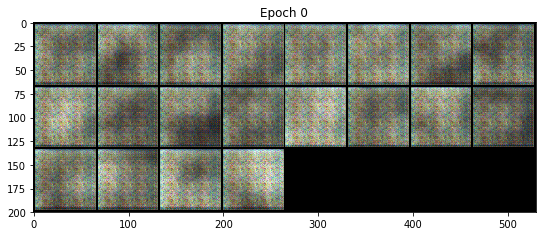

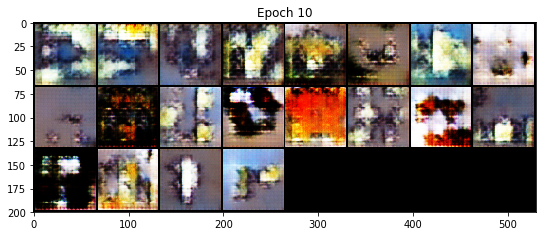

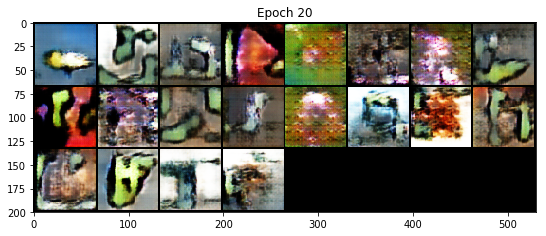

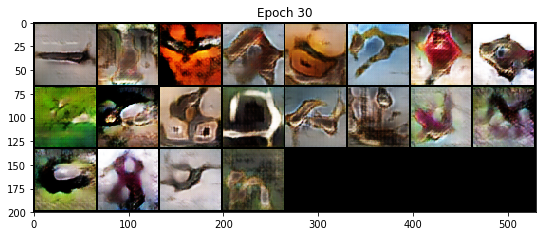

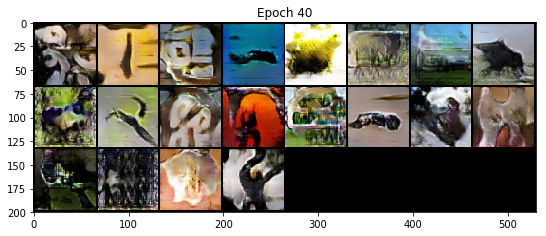

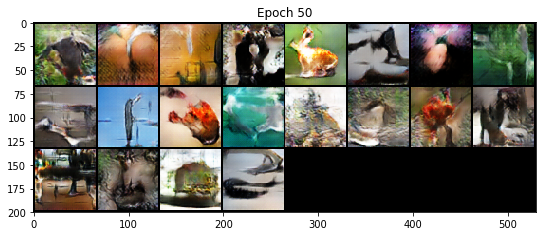

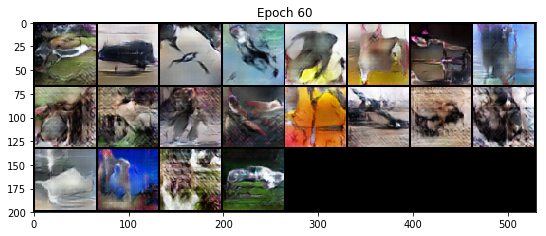

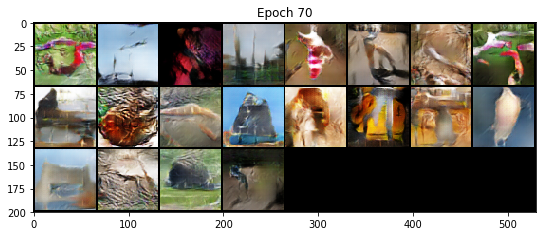

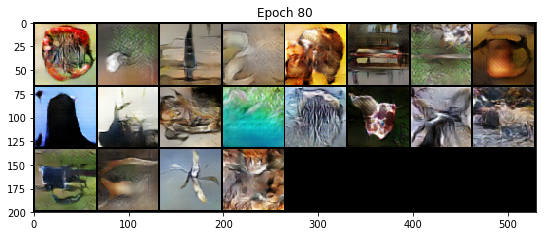

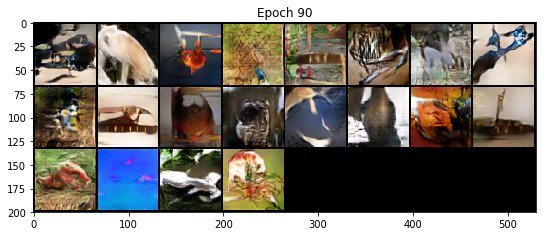

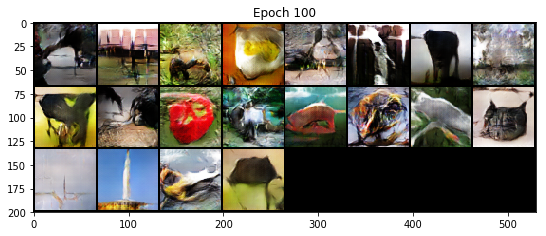

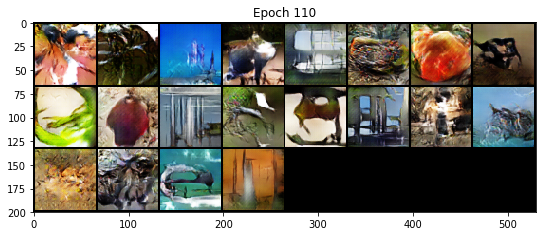

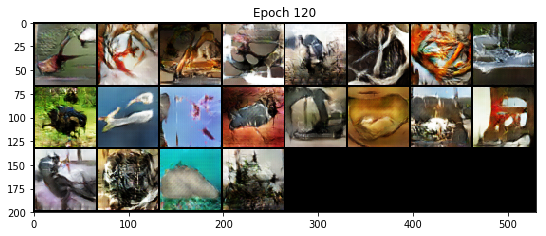

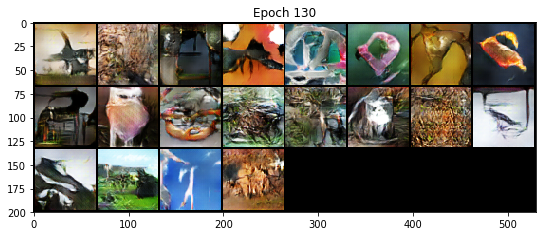

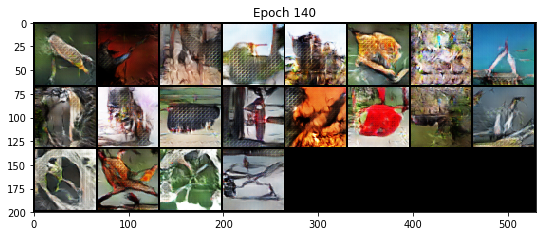

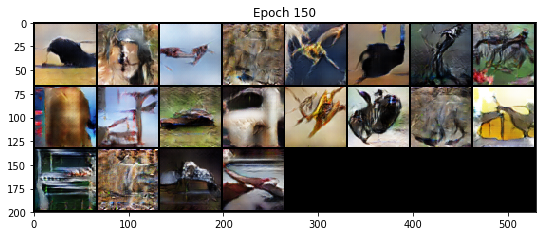

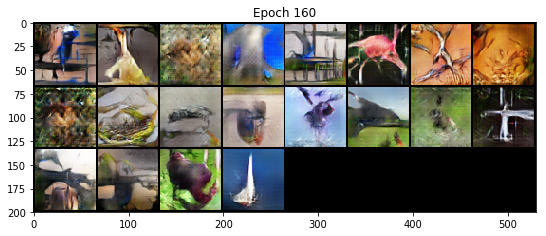

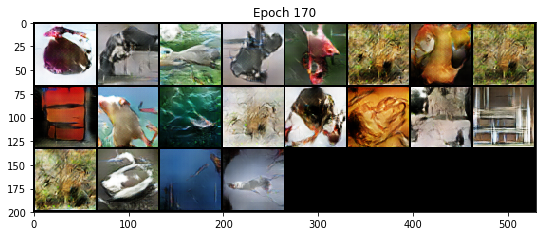

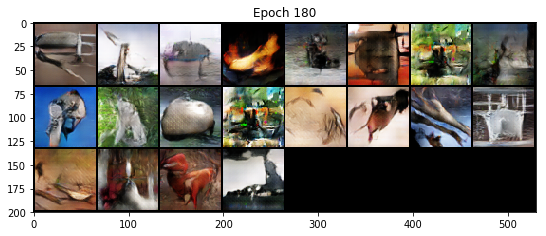

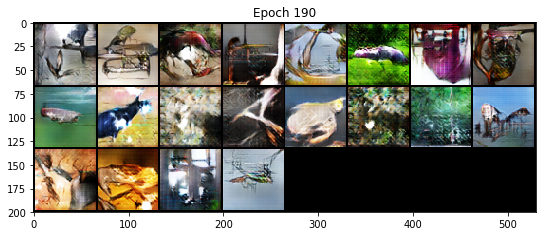

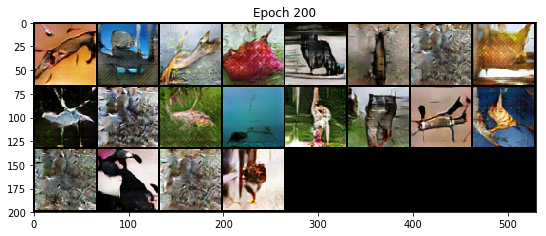

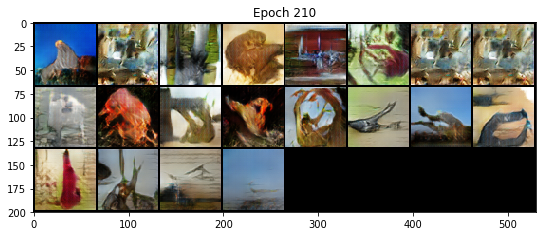

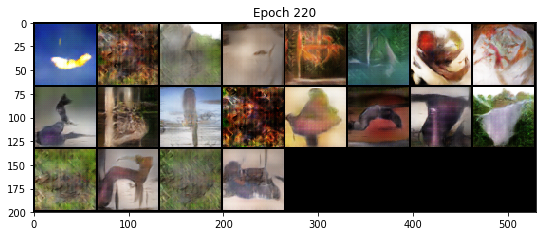

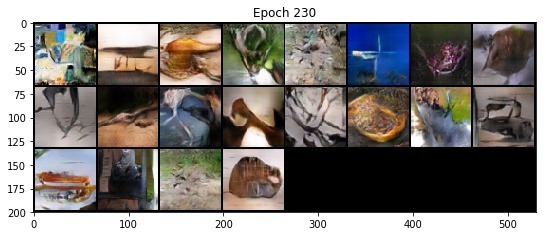

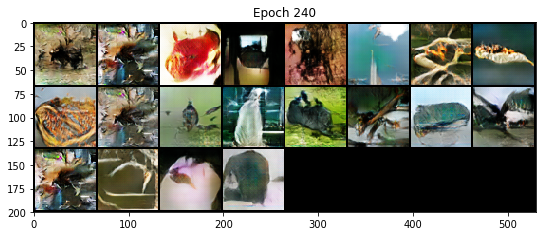

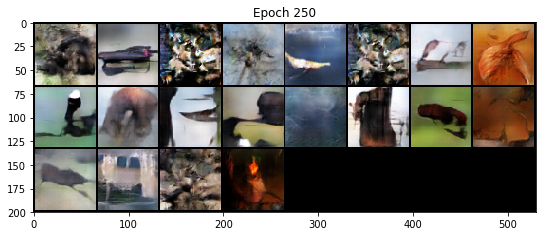

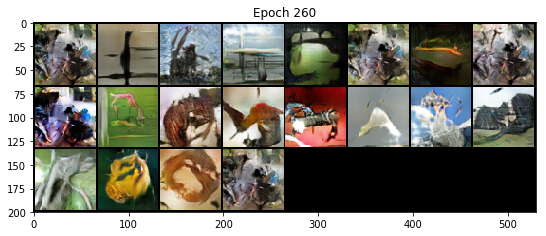

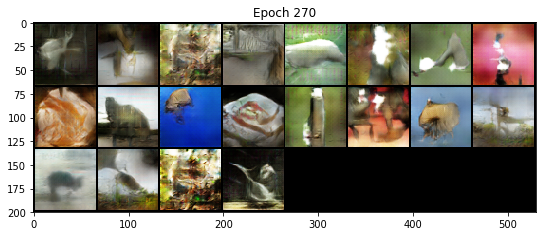

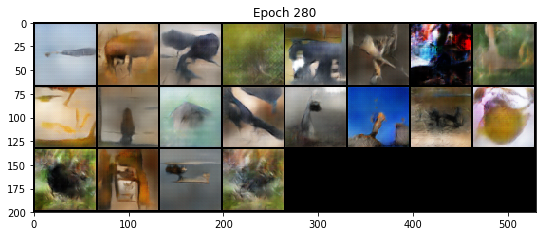

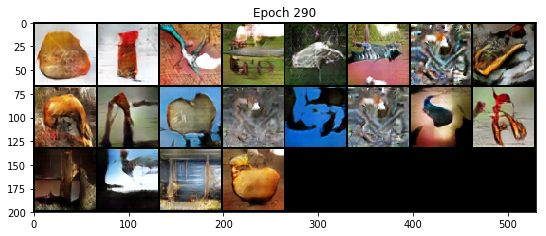

In [28]:
show_samples()

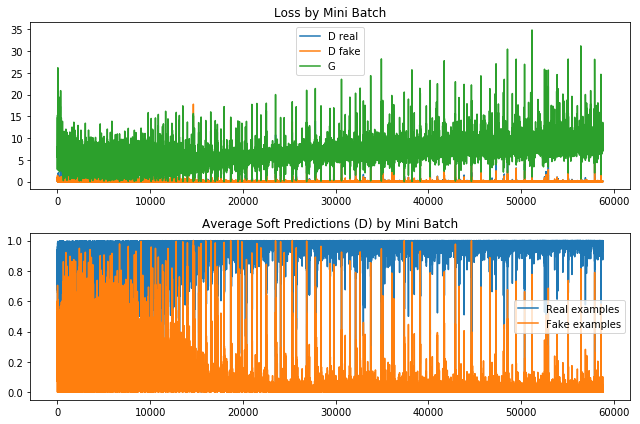

In [29]:
plot_output(output)